Emotion detection

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

2024-01-16 02:32:06.895434: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 02:32:06.941691: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 02:32:06.941720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-16 02:32:06.943159: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-16 02:32:06.950770: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 02:32:06.951271: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
train_dir = "./input/train"
test_dir = "./input/test"
img_size = 48

In [3]:
train_datagen = ImageDataGenerator(width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         validation_split = 0.2
                                        )

validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [4]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [5]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def inception_module(x, filters):
    # Each branch of the Inception module
    branch1x1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    branch3x3 = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    branch3x3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(branch3x3)

    branch5x5 = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    branch5x5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(branch5x5)

    branch_pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(branch_pool)

    # Concatenate all the branches
    x = concatenate([branch1x1, branch3x3, branch5x5, branch_pool], axis=-1)
    return x

# Define the input
input_img = Input(shape=(48, 48, 1))

# Apply some Conv and MaxPooling layers before the Inception modules
x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', kernel_regularizer=l2(0.01))(input_img)
x = MaxPooling2D((3, 3), padding='same', strides=(2, 2))(x)
x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D((3, 3), padding='same', strides=(2, 2))(x)

# Apply the Inception modules
x = inception_module(x, [64, 96, 128, 16, 32, 32])
x = inception_module(x, [128, 128, 192, 32, 96, 64])

# Apply Average Pooling and dropout
x = AveragePooling2D((7, 7), padding='same')(x)
x = Dropout(0.4)(x)

# Final layers
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(7, activation='softmax')(x)

# Create the model
model = Model(input_img, x)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


2024-01-16 02:32:13.948534: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 24, 24, 64)           3200      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 12, 12, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 12, 12, 192)          110784    ['max_pooling2d[0][0]']   

In [13]:
epochs = 1
batch_size = 64

In [14]:
history = model.fit(x = train_generator,epochs = epochs,validation_data = validation_generator)

359/359 [==============================] - 80s 223ms/step - loss: 0.7053 - accuracy: 0.7476 - val_loss: 1.2930 - val_accuracy: 0.5726


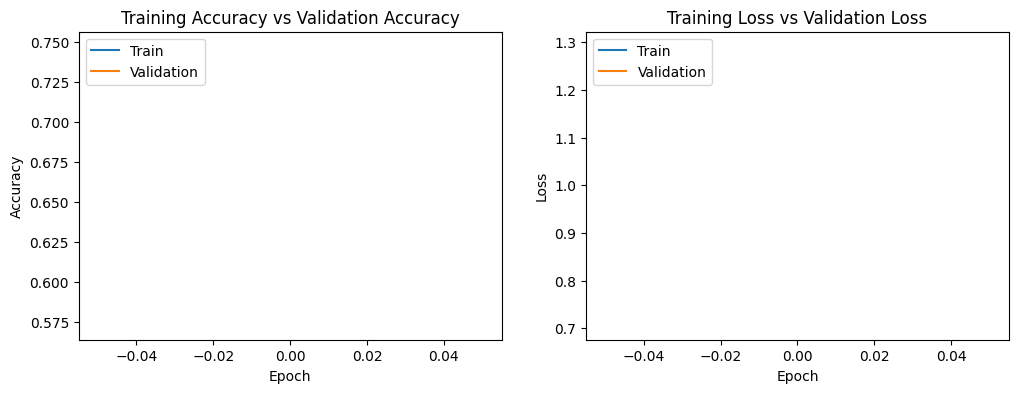

In [27]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [16]:
model.save('googlenet_model.keras')

(48, 48)


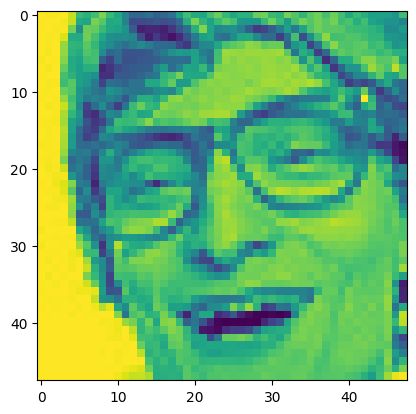

In [17]:
img = image.load_img("./input/test/happy/PrivateTest_10516065.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape) #prints (48,48) that is the shape of our image

In [18]:
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

In [19]:
img = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
img = img.reshape(1,48,48,1)
result = model.predict(img)
result = list(result[0])
print(result)

1/1 [==============================] - 0s 194ms/step
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]


In [20]:
img_index = result.index(max(result))
print(label_dict[img_index])
plt.show()

Happy


In [23]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

23/23 [==============================] - 1s 40ms/step - loss: 1.2930 - accuracy: 0.5726
final train accuracy = 82.08 , validation accuracy = 57.26


In [22]:
model.save_weights('model_weights.h5')

Found 7178 images belonging to 7 classes.
113/113 [==============================] - 4s 37ms/step


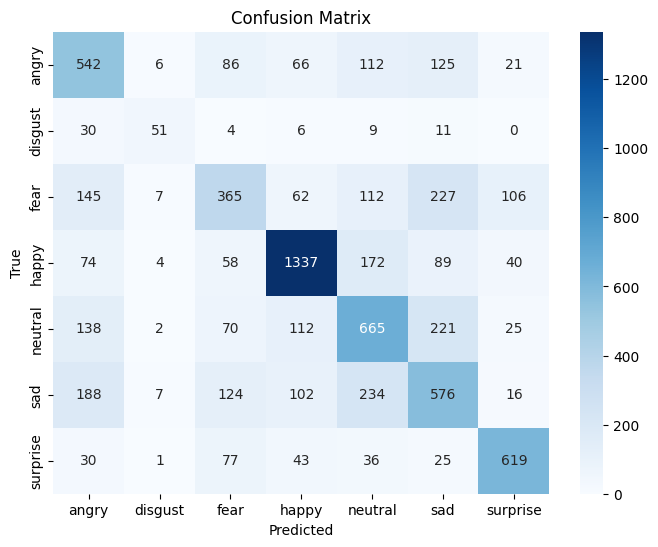

In [26]:
from sklearn.metrics import confusion_matrix

# Confusion matrix
# Generate batches of tensor image data for testing
test_prediction_generator = validation_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_size, img_size),
    batch_size=64,
    color_mode="grayscale",
    class_mode=None,  # Set to None for predictions
    shuffle=False      # Do not shuffle for confusion matrix
)

# Generate predictions on the test set
y_pred = model.predict(test_prediction_generator, verbose=1)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true class labels
y_true = test_prediction_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices, yticklabels=train_generator.class_indices)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
